# Predicting Patient Survival from After Diagnosis with NSCLC

In this project, the survival of patients will be predicted 1-year after being diagnosed with Non-small cell lung cancer (NSCLC). Survival is going to be the target/dependent variable in this study which can take one of two values (True/False or 1/0) and as such this is a classification problem.

## Things to address:
1. Describe data exploration (i.e., dealing with missing/bad entries, any interesting trends, descriptive statistics,etc.)
2. What features will be used for the model?
3. What algorithm to use for prediction?
4. How will model performance be assessed?
5. Future work?
 
 ## Part 1: Importing Necessary Modules

In [479]:
#General modules
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
import numpy as np
from math import nan, isnan
from tqdm import *
import time

#Plotting modules
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns

#For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Get ML  classifiers
#Linear Models
from sklearn.linear_model import Perceptron
#Naive Bayes Models
from sklearn.naive_bayes import GaussianNB
#Gaussian Process Models
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
#Ensemble Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
#XGB Model
from xgboost import XGBClassifier
#Neighbors Models
from sklearn.neighbors import KNeighborsClassifier
#Tree Models
from sklearn.tree import DecisionTreeClassifier 
#SVC Models
from sklearn.svm import SVC
#Neural Network Models
from sklearn.neural_network import MLPClassifier

#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

#For data splitting
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.utils import class_weight

#Get model metrics for model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc,make_scorer, classification_report,roc_auc_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

#For parameter grid search
from sklearn.model_selection import GridSearchCV

#For confusion matrix display
import scikitplot as skplt

#For simplified understanding of the importance model features
#import eli5
from eli5.sklearn import PermutationImportance
# Ignore the warnings to remove messy output logs
#import warnings
#warnings.filterwarnings('ignore')

## Part 2: Loading the Data
The data to be loaded is in two .csv files named clinical.csv and genomics.csv. As such it can be readily loaded using the pandas function 'read_csv'.

In [331]:
#Load the data
clinical_df = pd.read_csv('clinical.csv')
genomics_df = pd.read_csv('genomics.csv')

## Part 3: Basic exploration of the clinical data  

In [332]:
clinical_df

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
1,2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
2,3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
3,4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
4,5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,186,Dead,32.0,82,9,0,4,0.0,1.0,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2
186,187,Dead,10.0,62,4,0,3,2.0,NaN,0,IVB,Left Hilar,Large-cell carcinoma,NaN,3,5
187,188,Dead,23.0,72,3,0,3,NaN,NaN,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3
188,189,Dead,32.0,67,4,1,1a,NaN,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3


Hmmm, this dataset is rather small (only 190 patients) so I'll have to ensure that I preserve as much data as possible when dealing with any bad/missing entries to maximize the effectiveness and predicatability of my model(s).

I also have 16 different data features. The Outcome column is of particular interest since this will be my model target (i.e., did the patient survive or not at the time of checkup). Hence, I have initially 15 potential base features to build my model with.

Let me check the datatypes I have present

In [333]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    float64
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  125 non-null    float64
 8   M                  94 non-null     float64
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         98 non-null     float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(7), o

I have a mix of int64, float64, and objects. 

Let me see how many missing values there are

In [334]:
clinical_df.isnull().sum()

ID                    0
Outcome               0
Survival.Months       0
Age                   0
Grade                 0
Num.Primaries         0
T                     0
N                    65
M                    96
Radiation             0
Stage                 0
Primary.Site          0
Histology             0
Tumor.Size           92
Num.Mutated.Genes     0
Num.Mutations         0
dtype: int64

Hmmm, most columns have no missing values. Great!

Let me visualize this via a missing value matrix.

Text(0.5, 1.0, 'Heatmap of missing values')

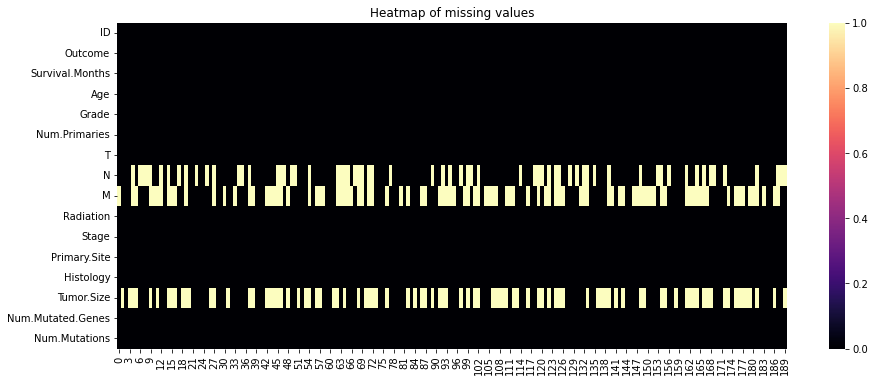

In [335]:
fig = plt.figure(figsize=(15,6))
sns.heatmap(clinical_df.isna().T, cmap='magma')
plt.title('Heatmap of missing values')

From the missing value matrix it can be seen that columns N,M and Tumor.Size have 65,96, and 92 missing entries.

* N is the number of metastasis to lymph nodes

* M is the numbers of distant metastases ('A distant metastasis refers to cancer that has spread from the original (primary) tumor to distant organs or distant lymph nodes. Also known as distant cancer.')

* Tumor.Size is the size of the tumor at the time of diagnosis

N,M,and Tumor.Size are of type float and as such are numerical continuous variables. The simplest way to deal with these missing entries is to fill them with either the median or the mode of the category depending on the shape of their distribution.


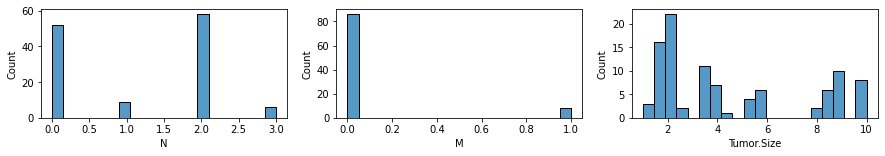

In [336]:
fig, ax = plt.subplots(1,3,figsize=(15,2))
ax = ax.ravel()
i = 0
nan_list = ['N','M','Tumor.Size']
for i  in range(3):
    sns.histplot(data = clinical_df, x = nan_list[i],ax=ax[i],bins = 20)
plt.show()

Tumor.Size at first glance appears to not be unimodal and may be slightly right skewed. I could try to stabilize the variance via a square root transform or a log transform. 

Hmmm, upon closer inspection N and M appear to have at discrete integer values. N only occurs at values of 0,1,2, or 3 while M only has values of 0 or 1. 

Let me check the number of unique values to ensure that's the case.

In [337]:
clinical_df.nunique()

ID                   190
Outcome                2
Survival.Months       28
Age                   20
Grade                  4
Num.Primaries          2
T                      9
N                      4
M                      2
Radiation              2
Stage                  9
Primary.Site           9
Histology              3
Tumor.Size            19
Num.Mutated.Genes      9
Num.Mutations          9
dtype: int64

Yep, N only has 4 unique values and M only has two unique values. As such, I will treat them as categorical variables instead which means that I will fill the empty entries of these two features with the mode. I will convert them to type 'int' as well.

In addition to this, since the Tumor.Size data is skewed, I will populate the missing entries with the median.

I also noticed that the Surival.Months column is being treated as a float, but it could be treated as an int for easier one hot encoding later. I'll make sure to convert it to that.

In [338]:
clinical_df2 = clinical_df.copy()
#Populate missing entries of N and M with the mode, and missing entries in Tumor.Size with the median
clinical_df2['N'].fillna(clinical_df2['N'].mode()[0], inplace=True)
clinical_df2['M'].fillna(clinical_df2['M'].mode()[0], inplace=True)
clinical_df2['Tumor.Size'].fillna(clinical_df2['Tumor.Size'].median(), inplace=True)
#Convert N and M to type int
clinical_df2 = clinical_df2.astype({"N": int, "M": int, "Survival.Months": int})
clinical_df2.isnull().sum()

ID                   0
Outcome              0
Survival.Months      0
Age                  0
Grade                0
Num.Primaries        0
T                    0
N                    0
M                    0
Radiation            0
Stage                0
Primary.Site         0
Histology            0
Tumor.Size           0
Num.Mutated.Genes    0
Num.Mutations        0
dtype: int64

No more NaNs! Let me ensure the types are parsed correctly so far.

In [339]:
clinical_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    int32  
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  190 non-null    int32  
 8   M                  190 non-null    int32  
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         190 non-null    float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(1), int32(3), i

Great! Now I'll get the basic descriptive statistics for this dataset

In [340]:
clinical_df2.describe()

,ID,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,95.500000,22.178947,70.173684,6.105263,0.226316,1.436842,0.042105,1.657895,4.061579,2.684211,3.084211
std,54.992424,12.428401,6.146909,2.995495,0.419551,0.927938,0.201360,2.360122,2.231247,1.460327,1.697575
min,1.000000,9.000000,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.250000,11.000000,67.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.600000,2.000000,2.000000
50%,95.500000,16.000000,71.000000,9.000000,0.000000,2.000000,0.000000,0.000000,3.600000,3.000000,3.000000
75%,142.750000,34.000000,74.000000,9.000000,0.000000,2.000000,0.000000,5.000000,3.600000,3.000000,4.000000
max,190.000000,71.000000,84.000000,9.000000,1.000000,3.000000,1.000000,5.000000,10.000000,8.000000,8.000000


## Part 4: Merging Dataframes
I've done initial clean-up and exploration of the data so far, before I do any subsequent visualization however, I want to briefly explore the genomics.csv file since it looks like I'll be able to merge these two dataframes together and include the Mutated Genes into the clinical_df based on the Patient ID. This will allow to create the number of features in my model quite a bit so it's a bit of a freebie in terms of feature engineering.

I will assume that the patients with the same ID contained within the genomics.csv data correspond to the patients with that ID on clinical.csv

In [341]:
genomics_df

,ID,Gene
0,1,AKT1
1,158,AKT1
2,88,ALK_Col1
3,132,ALK_Col1
4,18,ALK_Col2
...,...,...
505,167,TSC2
506,168,TSC2
507,180,TSC2
508,182,TSC2


Before anything else, I'll ensure that there are no missing values. 

In [342]:
genomics_df.isnull().sum()

ID      0
Gene    0
dtype: int64

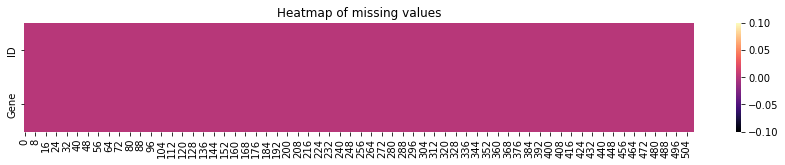

In [343]:
fig = plt.figure(figsize=(15,2))
sns.heatmap(genomics_df.isna().T, cmap='magma')
plt.title('Heatmap of missing values')
plt.show()

Great! NO missing data!

There are 510 entries on this dataframe. The clinical data has info for 190 patients. Are these 510 entries for unique patients?

In [344]:
genomics_df.nunique()

ID      184
Gene     50
dtype: int64

Hmm, there 184 unique patient IDs. Therefore, I should reshape my dataframe before continuing to better reflect this.

In [345]:
df2 = genomics_df.pivot(index='ID',columns='Gene',values='Gene')
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AKT1,NaN,NaN,NaN,NaN,NaN,NaN,CCND2,NaN,NaN,NaN,EGFR,NaN,NaN,NaN,NaN,NaN,FGFR3,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDGFRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK11,NaN,NaN,NaN,TSC2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMO,NaN,NaN,TP53_Col1,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK11,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDKN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIK3CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,TSC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NF_Col3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KRAS_Col1,NaN,NaN,NaN,NaN,MSH2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TSC2
188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDKN2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TP53_Col1,NaN,NaN


Ok, this is better. There is gene information for 184 patients. I don't want to drop any patients from my dataset because it is already fairly small, so instead I'll figure out which patients are missing genomic data and then simply enter NaN values for their gene info before I merge them. 

In [346]:
#Find missing integers within a given range in a list
gene_patients = df2.index.tolist() 

def find_missing(ls,ini,fin):
    """
    Args:
        ls: list to look missing numbers in
        ini: Beginning of range to look for integers in
        ini: End of range to look for integers in
        
    Returns:
        List of values missing from list
    """
    print('The missing patients are:')
    return [x for x in range(ini, fin + 1) if x not in ls]
  
ini = 1
fin = 190
print(find_missing(gene_patients,ini,fin))

The missing patients are:
[19, 30, 40, 89, 142, 166]


Nice! The missing patients are those with IDs of 19,30,40,89,142,166.

Now I have to decide how to handle them. I can either set the gene values to NaN (i.e., missing for these 6 patients after I merge the dataframes) or I can drop these 6 patients from the dataset and keep only the patients for whom I have a full set of data. 

If I were to fill in the gene values with missing or 0 or whichever constant filler value, then this would confound the model and may lead to more false positives/negatives. This is particularly troublesome in this scenario since a false positive would entail telling the patient that they will survive when they aren't going to, and a false negative would entail telling the patient that they will die when they are going to live.  

Given that, I think I've convinced myself that dropping these 6 patients for the time being is the right course of action. I can always come back and include them later and handle them in a more appropriate fashion if need be.

I'll fill the NaN values with 0 for this dataframe.

In [347]:
df2 = df2.fillna(0)
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,AKT1,0,0,0,0,0,0,CCND2,0,0,0,EGFR,0,0,0,0,0,FGFR3,0,0,0,0,KRAS_Col1,0,0,0,0,0,0,0,0,0,0,0,0,PDGFRB,0,0,0,0,0,0,0,0,0,STK11,0,0,0,TSC2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SMO,0,0,TP53_Col1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,STK11,0,0,0,0
4,0,0,0,0,0,0,0,0,CDKN2A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MET,0,0,0,0,0,0,0,0,0,0,0,PIK3CB,0,0,0,0,0,0,0,0,0,TP53_Col1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KRAS_Col1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TP53_Col1,0,TSC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NF_Col3,0,0,0,0,0,0,0,0,PTEN,0,0,0,0,0,0,0,0,0
187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KRAS_Col1,0,0,0,0,MSH2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TSC2
188,0,0,0,0,0,0,0,0,CDKN2A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,MET,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TP53_Col1,0,0


Nice! One more thing that I should is replace all nonzero values in each column with a 1. This is a bit of a roundabout way to get these gene features one hot encoded.

In [348]:
for col in df2.columns:
    df2.loc[df2[col] != 0, col] = 1
df2

Gene,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
188,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Perfect! Now I'm ready to merge these two dataframes. 

In [349]:
data_complete = clinical_df2.merge(df2, on="ID",how="inner")
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
0,1,Alive,9,67,4,0,UNK,2,0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,2,Dead,19,73,2,0,UNK,2,0,5,IV,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
182,189,Dead,32,67,4,1,1a,2,0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Awesome! The data I'll be working with now has 184 patients and I currently have 65 features to work with. Now I'll start visualizing these features and see if there's some more feature engineering I can do.

## Part 5: Visualizing Data Features and Data Engineering
I'll start by visualizing some of the variables that were present in the original clinical.csv data

In [350]:
data_complete.nunique()[:16]

ID                   184
Outcome                2
Survival.Months       27
Age                   20
Grade                  4
Num.Primaries          2
T                      9
N                      4
M                      2
Radiation              2
Stage                  9
Primary.Site           9
Histology              3
Tumor.Size            19
Num.Mutated.Genes      8
Num.Mutations          8
dtype: int64

In [351]:
def pie_plotter(features):
    """
    Args:
            ls: list of columns to make dataframes for
        Returns:
            Makes pie charts for features 
    """
    fig = plt.figure(figsize=(22,20))
    i = 0
    n_features = len(features)
    for feature in features:
        cardinality = data_complete[feature].nunique()
        colors  = pl.cm.coolwarm(np.linspace(0,1,cardinality))
        explode = [0.1] * cardinality

        labels = data_complete[feature].unique()   
        labels = [x for x in labels if str(x) != 'nan']

        ax1 = plt.subplot2grid((1,n_features),(0,i))
        plt.pie(data_complete[feature].value_counts(),autopct='%1.1f%%',textprops={'fontsize':14},colors = colors,shadow=True,labels=labels,explode = explode)
        plt.title(feature)
        i+=1
    plt.show()

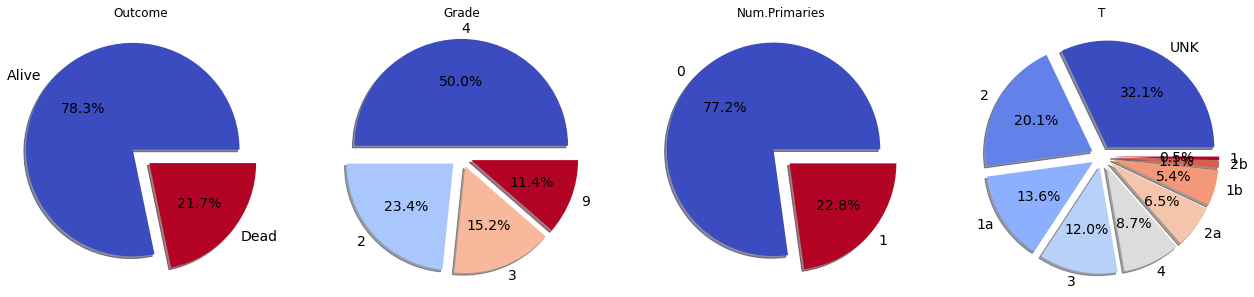

In [352]:
features = ['Outcome','Grade', 'Num.Primaries', 'T']
pie_plotter(features)

### Observations:
* 78.3% of patients were alive a year after being diagnosed with NSCLC
* 50% of patients had a tumor grade of 4 (cells look as abnormal as they can [this is bad]). Also, there are no patients with a tumor grade of 1, 
* 77.2% of patients have a value of 0 for Primary tumors
* 32.1% of patients have a tumor at an unknown stage. 20.1% of patients have a tumor of stage 2.

### Takeaways:
* NSCLC diagnosis appears to have close to 80% survival rate a year after initial diagnosis. 
* Also,since this is my target class, this makes this problem an <strong>inbalanced classification problem</strong>.
* The dataset is already small so I don't want to use under-sampling of the minority class since this involves discarding data. Oversampling though could be a good way forward but it may result in overfitting. 
* Adding class weights may be a good way forward that won't require synthetic creation of data or discarding of data.
* I'll also need to take a close look at the confusion matrix, recall, F1 scores, AUC-ROC scores as well as the sensitivity and specificity of the model predictions.
* Decision Trees and Ensemble Methods are generally pretty good dealing with inbalanced data. So I'll test a variety of these to start with.
* Half of the patients had a Grade 4 tumor which is the most aggressive division a cancer can have
* Number of primary tumors has values of either 0 or 1. Does this mean that this value represent whether a primary tumor was present or not? In either case, nearly 80 percent of patients did not have a primary tumor at the time of diagnosis (Strong correlation with survival perhaps??)
* Maybe not having a tumor detected leads to increased survival


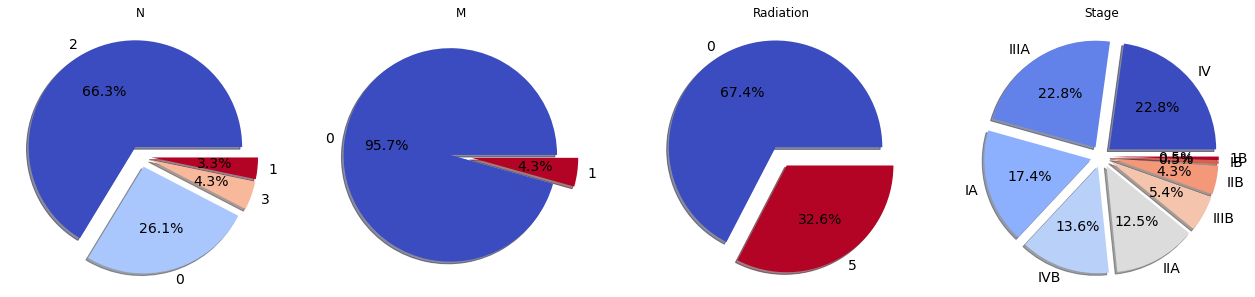

In [353]:
features = ['N','M', 'Radiation', 'Stage']
pie_plotter(features)

### Observations:
* 66.3% of patients had 2 metastasis to lymph nodes
* 95.7% of patients had no distant metastases
* 67.4% of patients no radiation exposure
* 22.8% of patients had a tumor stage of IV or IIIA at the time of diagnosis

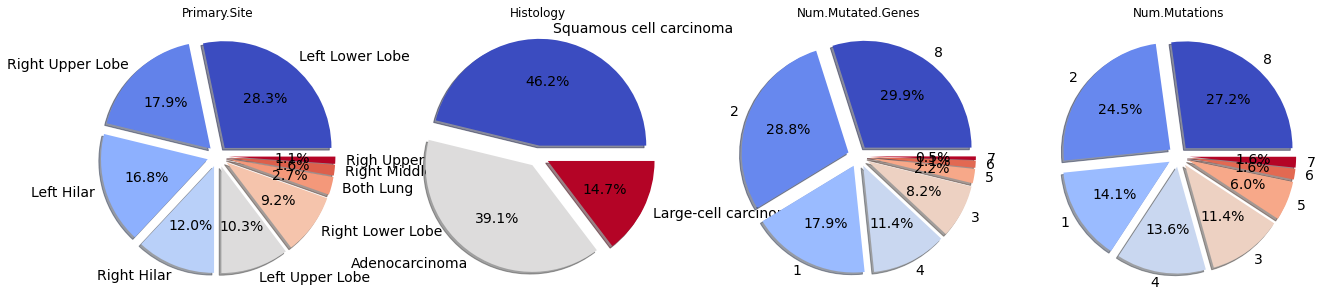

In [354]:
features = ['Primary.Site','Histology', 'Num.Mutated.Genes', 'Num.Mutations']
pie_plotter(features)

### Observations:
* 28.3% of patients had their primary site as the Left Lower Lobe
* 46.2% of patients had Squamous cell carcinoma (2nd most common form of skin cancer)
* 29.9% of patients had 8 mutations in the tumor followed by 28.8% of patients had 2 mutations in the tumor 
* 27.2% of patients had 8 genes with mutation and 24.5% of patients had 2 genes with mutation

## Visualizing Relationships Between Features and Patient Survival
Ok, now I want to see what proportion for these various features are associated with patient survival

In [355]:
def make_countplot(features):
    if len(features) < 4:
        fig, axs = plt.subplots(1,len(features),figsize=(20,4))
    else:
        fig, axs = plt.subplots(2,2,figsize=(15,8))
    ax = axs.ravel()
    i = 0
    for feature in features:
        sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
        ax[i].set_title(feature)
        i+=1
    fig.tight_layout() 
    plt.show()

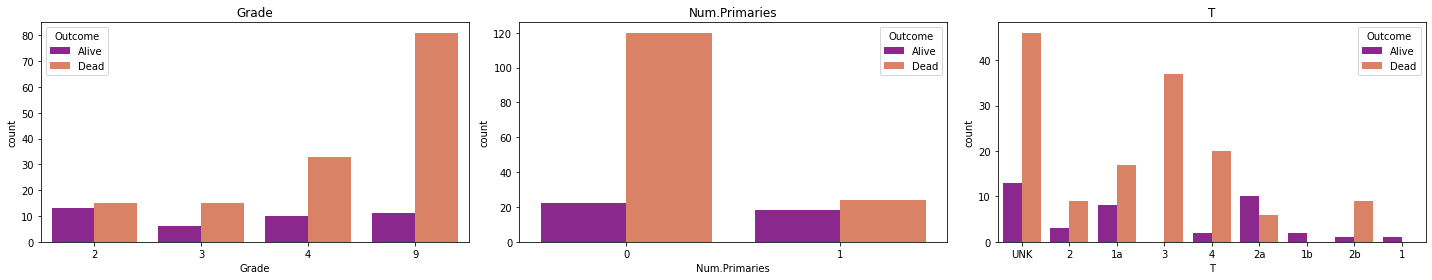

In [356]:
features = ['Grade', 'Num.Primaries', 'T']
make_countplot(features)

### Observations:
* All kinds of tumor grades result in a higher death rate than not
* The Undetermined tumor grade class (labeled as 9) has a disproportionately higher death rate than all other tumor grades.
* Having 0 as the number of primary tumors results in a much higher death rate than having 1 as the number of primary tumors
* Having a tumor in stage 3 results exclusively in patient death. 
* Stage 4, Stage UNK, and Stage 2b have disproportionately higher death rates
* Stage 2 and Stage 1a result in higher death rates than not
* Stage 2a, Stage 1b, and Stage 1 result in higher survival rates than not

### Thoughts:
* The cancer grade gives the an idea of how quickly a cancer might grow and how likely it is to spread. * Maybe I can generate a new set of features called 'Slow_Growth', 'Medium_Growth' , 'Fast_Growth' to denote growth speed based on the cancer grade.
* Maybe I can generate a new set of features called 'LessLikely_Spread', 'Likely_Spread' , 'HighlyLikely_Spread' to spread likelihood based on the cancer grade.
* Maybe I can generate a new set of features called 'Normal_Cells', 'Abnormal_Cells' , 'Most_Abnormal_Cells' to denote the morphology of the cell based on the cancer grade.

* The T values stands for Tumour in the TNM staging scheme. There are the 4 categories T1-T4 that denote cancer being present. These categories can be further subdivided to be more specific about the size of the tumour. In other words, T and Tumour.Size are connected. I should be able to break down tumor size into ranges.
* The other categories are TX, T0, and Tis. T0 means that there is no sign of cancer. TX means cancer cannot be assessed from scans but there may be evidence of it elsewhere. 


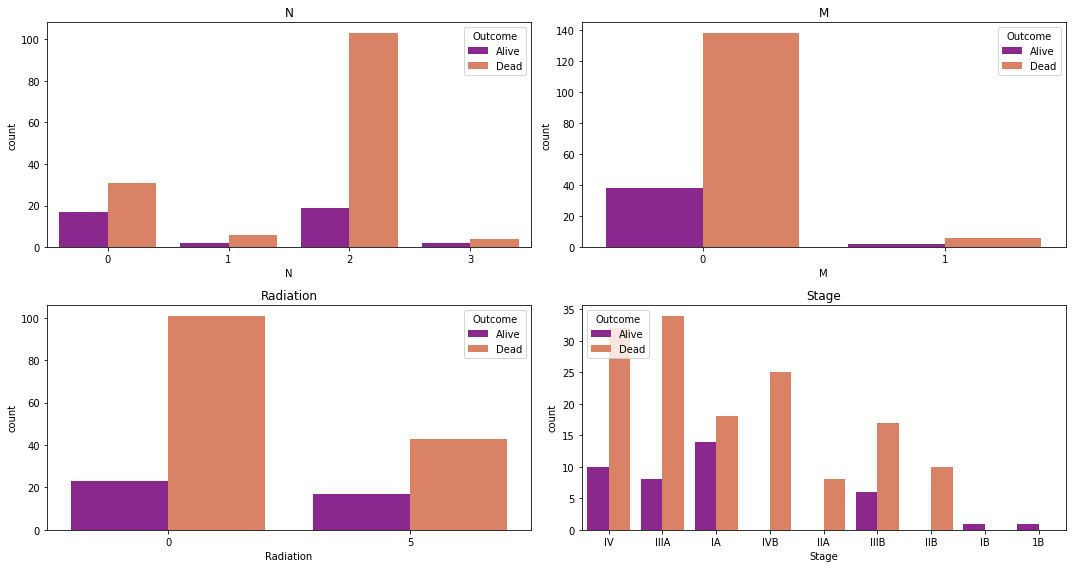

In [357]:
features = ['N','M', 'Radiation', 'Stage']
make_countplot(features)

### Observations:
* The death rate for having 2 metastasis to lymph nodes is much higher than all the other N values
* Having 0 distant metastases has a much higher death rate than not
* No exposure to radiation results in much higher death rates than those who were exposed to radiation
* Stages IB and 1B had higher survival rates than not. All other stages had higher death rates. 

### Takeaways:

From this reference: https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades I can see the following:
* Cancer is broken down into 4 stages: Stage 1,2,3 and 4. 
* Stage 1 can be broken down into Stage 1A and Stage 1B. Are stage IB and stage 1B the same thing and are just mislabeled?
* Stage 2 can be broken down into Stage 2A and Stage 2B. I see no issues here.
* Stage 3 can be broken down into Stage 3A,3B, and 3C. 3C is not present in the labels.
* Stage 4 can be broken down into Stage 4A and 4B. There is a Stage IV label (is this Stage 4A or does it include both?) and a Stage IVB.

### Other thoughts:
* N stands for node in the TNM staging scheme and describes whether cancer has spread to lymph nodes. There's 3 categories that indicate cancer being present N1-N3. N0 means that there are no cancer cells. NX means that lymph nodes can't be assessed (does not necessarily mean that cancer is not present).
* I think I could make a new feature called 'Spread_To_Lymph_Nodes' based on whether the N value is greater than 0.


* M stands for metastasis in the TNM staging scheme and describes whether the cancer has spread to a different part of the body. M has only two stages. M0 means that the cancer hasn't spread to other parts of the body while M1 means that the cancer has spread elsewhere.
* Maybe a feature called 'Spread_To_Body' could be useful? Though it seems redundant with the M value...


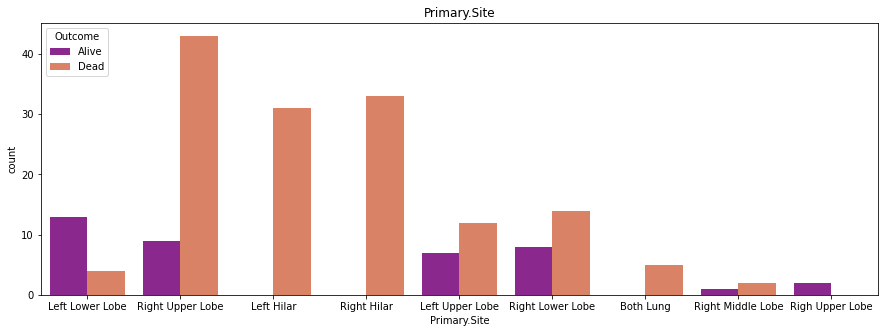

In [358]:
fig = plt.figure(figsize=(15,5 ))
sns.countplot(data=data_complete, 
              x='Primary.Site', 
              hue='Outcome', palette='plasma').set_title('Primary.Site')
plt.show()                                                                             

### Observations:
* If primary tumor site is left hillar, right hillar, or both lungs then there is no survival
* If primary tumor site is right upper lobe, left upper lobe, right upper lobe or right middle lobe then there is a higher death rate than not.
* The remaining categories have higher survival rates

### Thoughts:
* Maybe I can combine left and right hillar into a single category since both of these primary sites result in extremely high death rates?
* The final category 'Righ Upper Lobe' looks like a typo. Should this be 'Right Upper lobe'?
* Maybe I can also add a category that denotes whether the tumor was on the Right or Left side too?

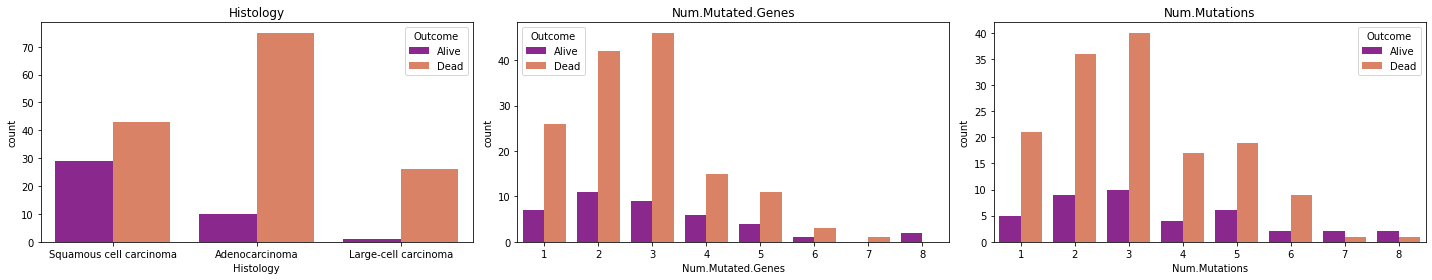

In [359]:
features = ['Histology', 'Num.Mutated.Genes', 'Num.Mutations']
make_countplot(features)

### Observations:
* Large-cell carcinoma and adenocarcinoma have much higher death rates than squamous cell carcinoma
* Patients with 8 mutated genes in the tumor had higher survival rates.
* All other numbers of mutated genes had higher death rates. The biggest difference in survival and not seem to be for 1,2,and 3 mutated genes
* The number of genes with mutations between 1-6 have higher death rates. The ones higher than 6 have higher survival rates.

Now I'll explore the numerical variables: survival months, age and tumor size before continuing

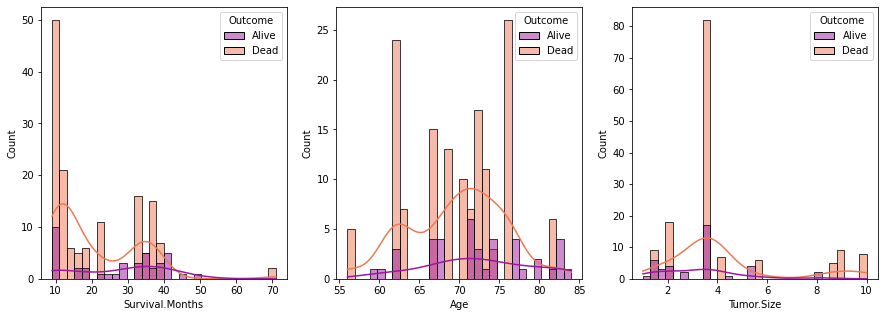

In [360]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.ravel()
i = 0
num_feats = ['Survival.Months','Age','Tumor.Size']
for i  in range(len(num_feats)):
    sns.histplot(data = data_complete, x = num_feats[i], 
                 hue='Outcome', palette='plasma', ax=ax[i],
                 bins = 30, kde=True)
plt.show()

### Observations on Survival.Months:

* Most patients died within the first 24 months since diagnosis.
* Between 24-30 months the survival rate was higher
* Between 32-38 months the death rate increased
* Between 40-50 months the survival rate increased
* After 50 months death rate increased
* Based on the KDE curves, this feature could be partitioned into 3 classes: 0-40 months, 40-50 months, and 50+ months
* The distribution appears to be bimodal/trimodal

### Recommendations on Survival.Months:

* Break down this category into either 3 or 5 classes based on observations above

### Observations on Age:

* All patients here are at least 55 years old. 
* The distribution appears to be bimodal.
* All patients died regardless of Age. 

### Recommendations on Age:

Since the distribution is bimodal maybe partition age into a group of 50-65 years old and a group of 65+ years old?

### Observations on Tumor.Size:

* The distribution appears to be bimodal.

### Recommendations on Tumor.Size:

Since the distribution is bimodal maybe partition tumor size into a group of 0-6 length units [cm?] and a group of 6+ length units?

## Part 6: Do different genes lead to higher/lower survival rates?
The genomics data contains information for over 50 genes. I want to determine which ones are associated with the highest survival/death rates.

In [361]:
def make_countplot_genes(features):
    fig, axs = plt.subplots(5,5,figsize=(20,15))
    ax = axs.ravel()
    i = 0
    for feature in features:
        sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
        ax[i].set_title(feature, fontsize=20)
        i+=1
    fig.tight_layout() 
    plt.show()

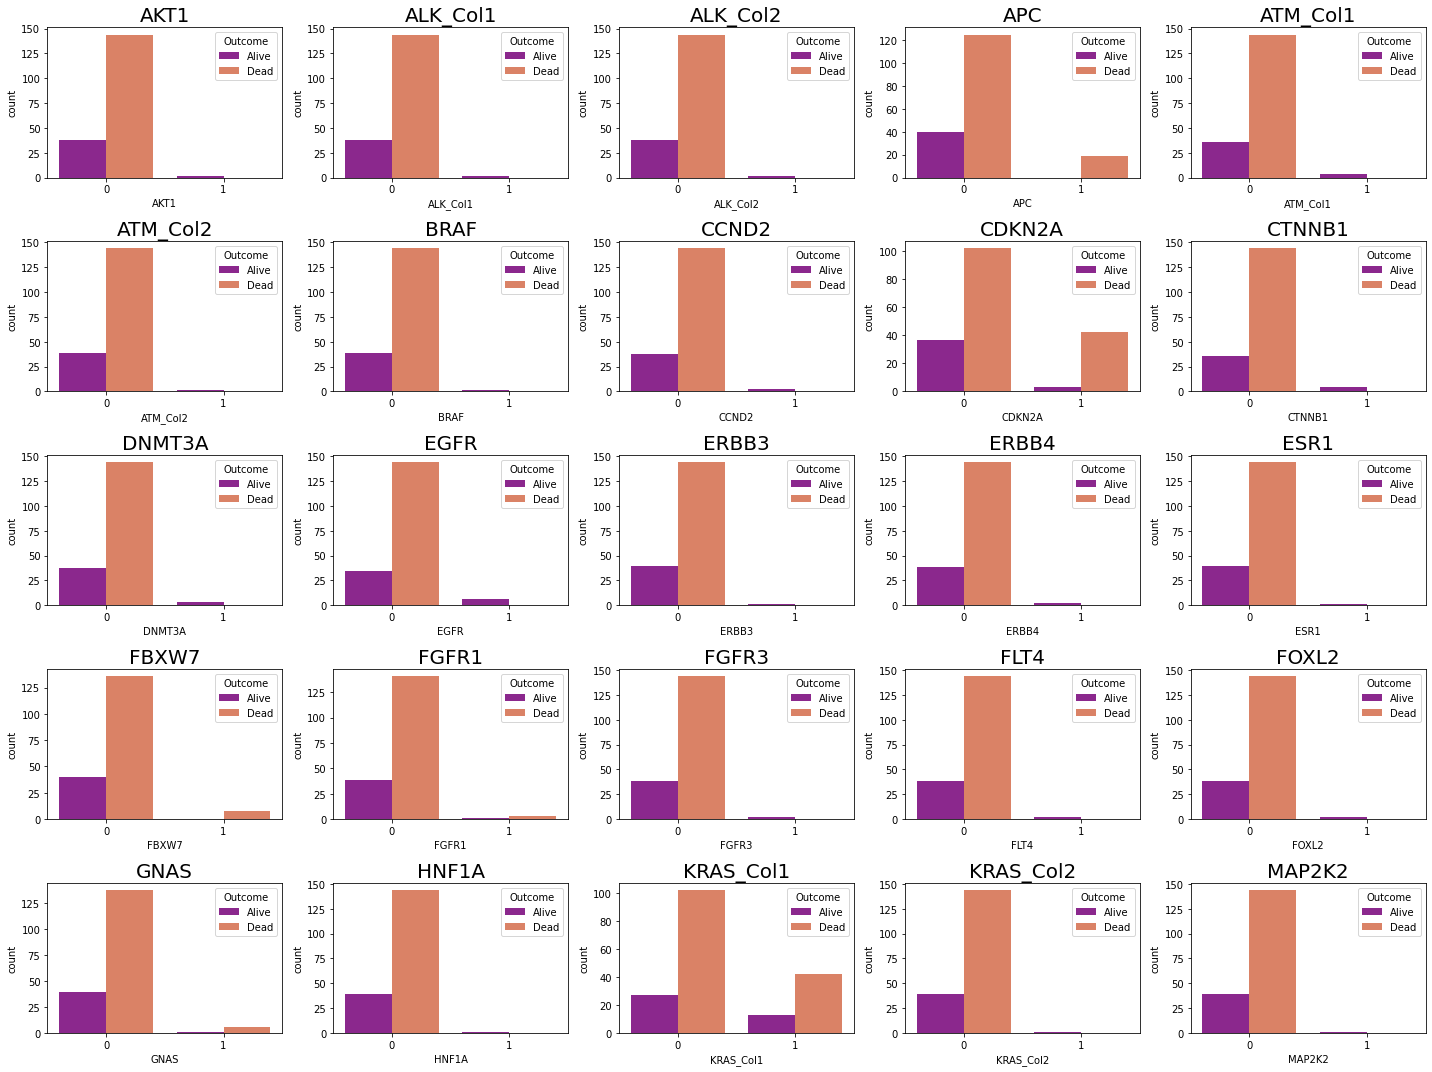

In [362]:
features = data_complete.columns[16:41]
make_countplot_genes(features)

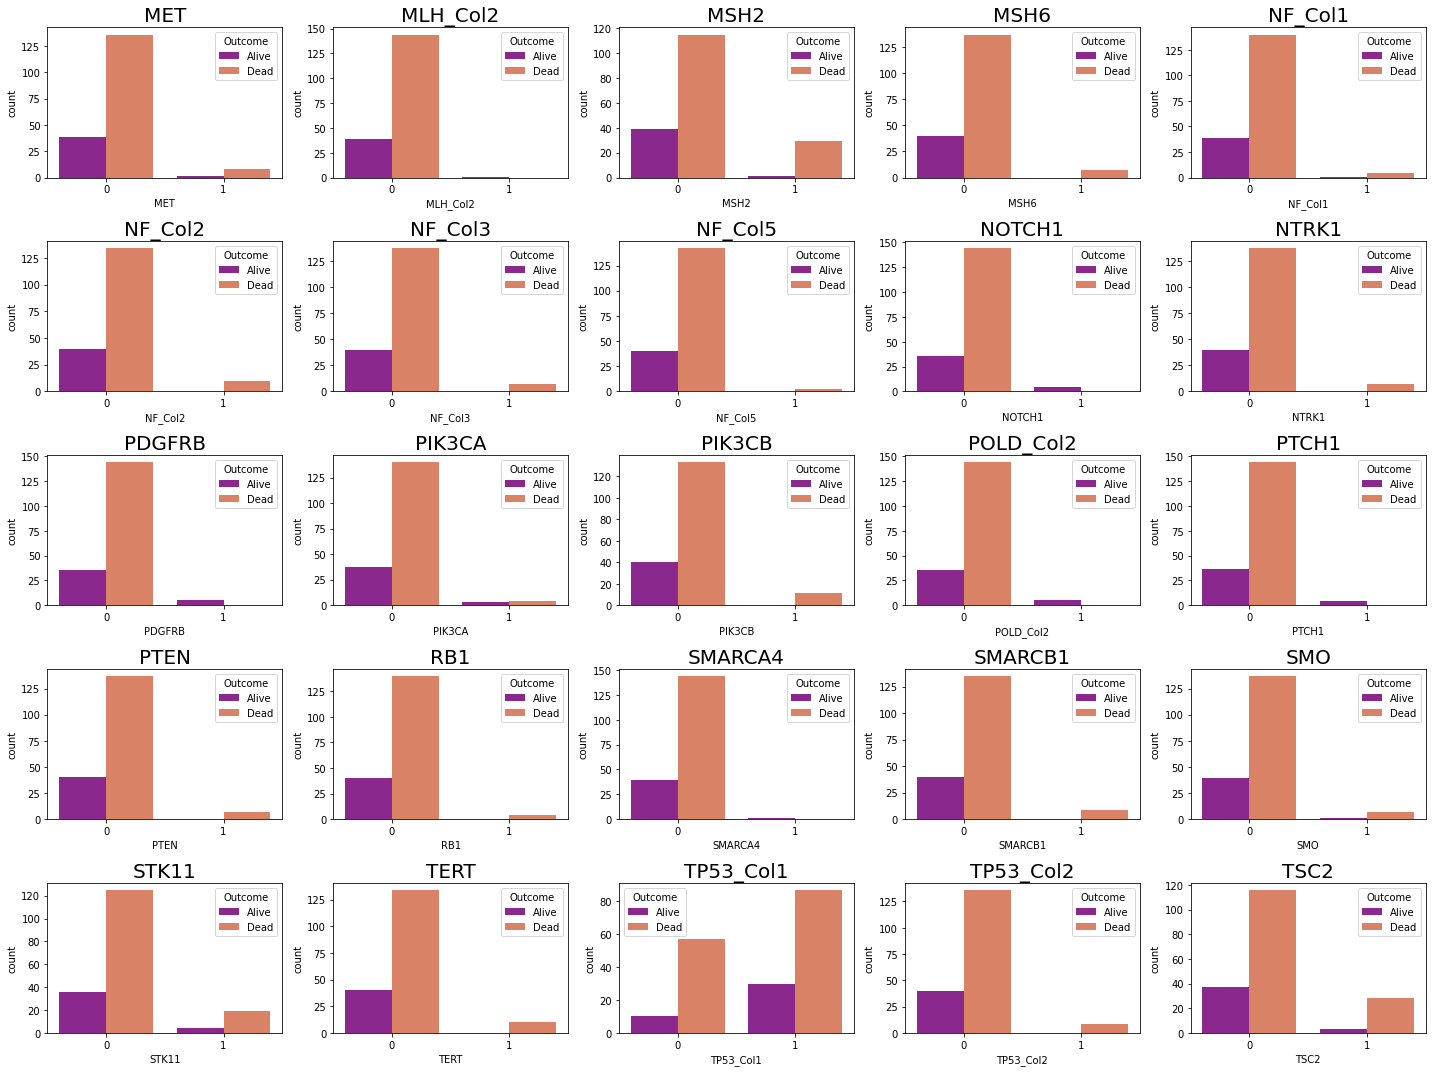

In [363]:
features = data_complete.columns[41:66]
make_countplot_genes(features)

In general, not having most of these genes results in high death rates. 

There's a few instances where having the gene INCREASED the death rate. Some examples can be seen at:
* TSC2, TP53_Col2,TERT,SMO,PTEN,NTRK1

There's a few instances where having the gene DECREASED the death rate. Some examples can be seen at:
* SMARCA4,PTCH1,POLD_Col2,PDGFRB,ATK1

If I had more time, I'd like to try to find commonalities between some of these genes to see if further refinement is possible. But for now, given the time constraints, I'll leave them as is.

## Part 7: Feature Engineering 
In Part 5, I explored the features present in the clinical dataset. I found a few places that I think I can use to engineer more features based on the data distributions/patterns. I'll take care of all of those in this section. I'll also clean up a few typos I noticed in a few of the features. 

In [364]:
#Functions to make growth,spread, and morphology features based on Cancer Grade
def make_slow_growth(row):
    if row['Grade'] == 2:
        val = 1
    else:
        val = 0
    return val

def make_med_growth(row):
    if row['Grade'] == 3:
        val = 1
    else:
        val = 0
    return val

def make_fast_growth(row):
    if row['Grade'] == 4:
        val = 1
    else:
        val = 0
    return val

In [365]:
#Make columns denoting tumor growth speed based on cancer grade
data_complete['Slow_Growth'] = data_complete.apply(make_slow_growth, axis=1)
data_complete['Medium_Growth'] = data_complete.apply(make_med_growth, axis=1)
data_complete['Fast_Growth'] = data_complete.apply(make_fast_growth, axis=1)
#Make columns denoting tumor spread likelihood speed based on cancer grade
data_complete['LessLikely_Spread'] = data_complete.apply(make_slow_growth, axis=1)
data_complete['Likely_Spread'] = data_complete.apply(make_med_growth, axis=1)
data_complete['HighlyLikely_Spread'] = data_complete.apply(make_fast_growth, axis=1)
#Make columns denoting cell morphology based on cancer grade
data_complete['Normal_Cells'] = data_complete.apply(make_slow_growth, axis=1)
data_complete['Abnormal_Cells'] = data_complete.apply(make_med_growth, axis=1)
data_complete['Most_Abnormal_Cells'] = data_complete.apply(make_fast_growth, axis=1)
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells
0,1,Alive,9,67,4,0,UNK,2,0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
1,2,Dead,19,73,2,0,UNK,2,0,5,IV,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
182,189,Dead,32,67,4,1,1a,2,0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1


Let me see how these new features behave in terms of predicting patient survival 

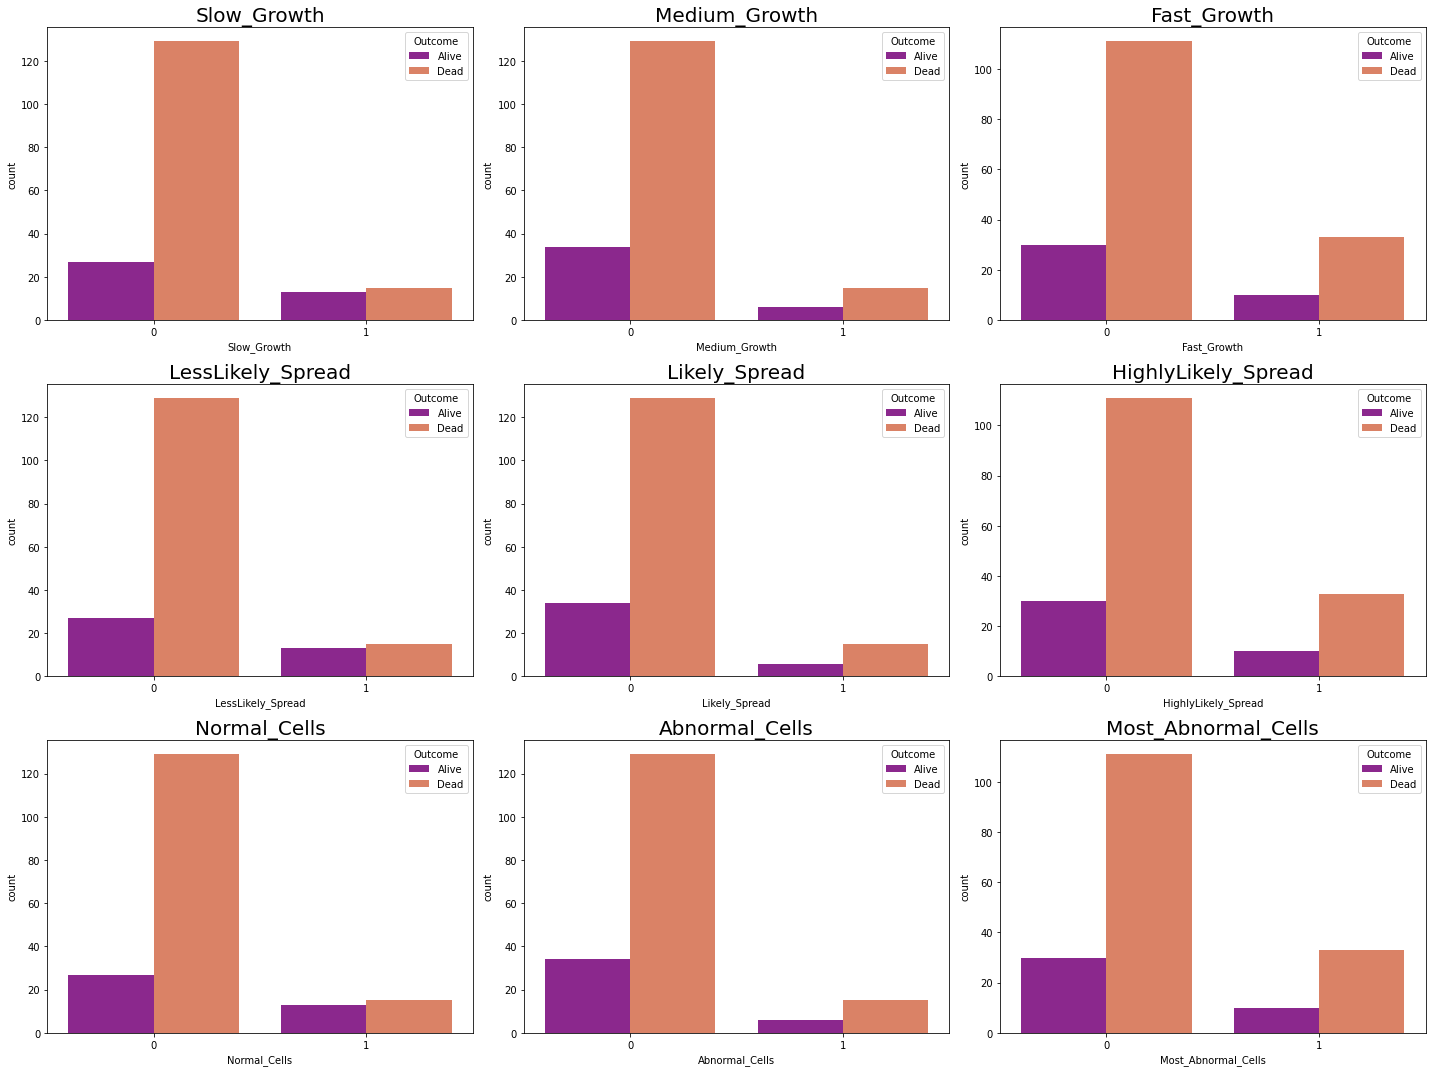

In [366]:
cancer_grade_new_feats = data_complete.columns[66:75]
fig, axs = plt.subplots(3,3,figsize=(20,15))
ax = axs.ravel()
i = 0
for feature in cancer_grade_new_feats:
    sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
    ax[i].set_title(feature, fontsize=20)
    i+=1
fig.tight_layout() 
plt.show()

Hmmm, the features derived from the cancer grade of 4 have a greater rate of mortality. 

Now I'll make the Spread_To_Lymph_Nodes column based on the T value.

In [367]:
def make_spread_to_lymph_nodes(row):
    if row['T'] != 'UNK':
        val = 1
    else:
        val = 0
    return val
#Make columns denoting cell morphology based on cancer grade
data_complete['Spread_To_Lymph_Nodes'] = data_complete.apply(make_spread_to_lymph_nodes, axis=1)
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes
0,1,Alive,9,67,4,0,UNK,2,0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1,2,Dead,19,73,2,0,UNK,2,0,5,IV,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1
182,189,Dead,32,67,4,1,1a,2,0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1


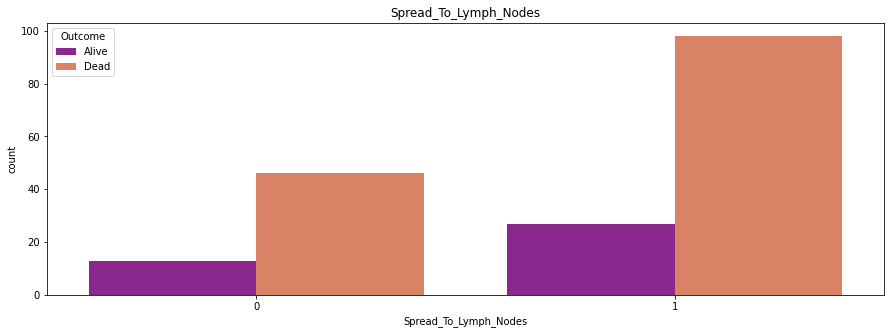

In [368]:
fig = plt.figure(figsize=(15,5 ))
sns.countplot(data=data_complete, 
              x='Spread_To_Lymph_Nodes', 
              hue='Outcome', palette='plasma').set_title('Spread_To_Lymph_Nodes')
plt.show() 

Mortality is high regardless. However, mortality rate is greater when the tumor has spread to lymph nodes.

Now, I'll make the Hilar feature since I saw really high mortality rate for the right and left hilar before. 

I'll also fix the typo I noticed for 'Righ Upper Lobe'

In [369]:
data_complete['Primary.Site'].unique()

array(['Left Lower Lobe', 'Right Upper Lobe', 'Left Hilar', 'Right Hilar',
       'Left Upper Lobe', 'Right Lower Lobe', 'Both Lung',
       'Right Middle Lobe', 'Righ Upper Lobe'], dtype=object)

In [370]:
data_complete['Primary.Site'].str.contains('Right')

0      False
1       True
2       True
3       True
4      False
       ...  
179     True
180    False
181     True
182     True
183     True
Name: Primary.Site, Length: 184, dtype: bool

In [371]:
#Make hilar identifier column
def make_hilar(row):
    if (row['Primary.Site'] == 'Left Hilar') | (row['Primary.Site'] == 'Right Hilar'):
        val = 1
    else:
        val = 0
    return val

#Fix typo in Primary.Site
def fix_typo_in_PS(row):
    if (row['Primary.Site'] == 'Righ Upper Lobe'):
        val = 'Right Upper Lobe'
    else:
        val = row['Primary.Site']
        
    return val

data_complete['Hilar'] = data_complete.apply(make_hilar, axis=1)
data_complete['Right_PS'] = data_complete['Primary.Site'].apply(lambda x: 1 if 'Right' in x else 0)
data_complete['Left_PS']  = data_complete['Primary.Site'].apply(lambda x: 1 if 'Left' in x else 0)
data_complete['Primary.Site'] = data_complete.apply(fix_typo_in_PS, axis=1)
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS
0,1,Alive,9,67,4,0,UNK,2,0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,2,Dead,19,73,2,0,UNK,2,0,5,IV,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
182,189,Dead,32,67,4,1,1a,2,0,0,IV,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0


And now I'll visualize these new features

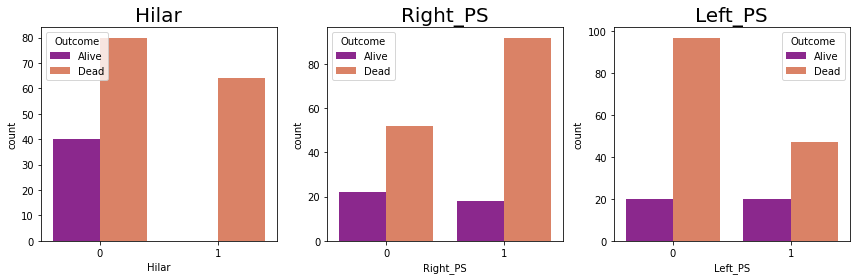

In [372]:
cancer_grade_new_feats = data_complete.columns[76:79]
fig, axs = plt.subplots(1,3,figsize=(12,4))
ax = axs.ravel()
i = 0
for feature in cancer_grade_new_feats:
    sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
    ax[i].set_title(feature, fontsize=20)
    i+=1
fig.tight_layout() 
plt.show()

Hmmm, if the primary site was the Hilar then the patient definitely died. Otherwise, they still have a pretty high chance of dying.

Interesting! There seems to be a higher chance of death if the primary site of the tumor is on the left. 

Now I'll fix the typo on the Stage column pertaining to 'IB' and '1B'. 

There is also the discrepancy in Stage IV and IVB. Should IV be labeled as IVA? If so, I could make two more columns that determine if the stage is classified as A or B...

I'll assume that IV corresponds to IVA so that I can do that.

In [373]:
#Fix typo in Stage
def fix_typo_in_Stage(row):
    if (row['Stage'] == 'IB'):
        val = '1B'
    elif (row['Stage'] == 'IV'):
        val = 'IVA'
    else:
        val = row['Stage']
        
    return val
data_complete['Stage'] = data_complete.apply(fix_typo_in_Stage, axis=1)
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS
0,1,Alive,9,67,4,0,UNK,2,0,0,IVA,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,2,Dead,19,73,2,0,UNK,2,0,5,IVA,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
182,189,Dead,32,67,4,1,1a,2,0,0,IVA,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0


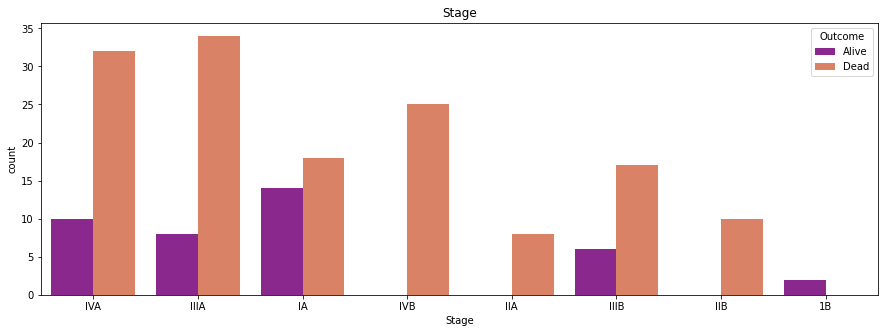

In [374]:
fig = plt.figure(figsize=(15,5 ))
sns.countplot(data=data_complete, 
              x='Stage', 
              hue='Outcome', palette='plasma').set_title('Stage')
plt.show() 

Ok, now I'll generate two more features that determine whether the cancer is stage A or B

In [375]:
data_complete['Stage_A'] = data_complete['Stage'].apply(lambda x: 1 if 'A' in x else 0)
data_complete['Stage_B'] = data_complete['Stage'].apply(lambda x: 1 if 'B' in x else 0)
data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS,Stage_A,Stage_B
0,1,Alive,9,67,4,0,UNK,2,0,0,IVA,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0
1,2,Dead,19,73,2,0,UNK,2,0,5,IVA,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,1
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0
182,189,Dead,32,67,4,1,1a,2,0,0,IVA,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0


And I'll visualize them

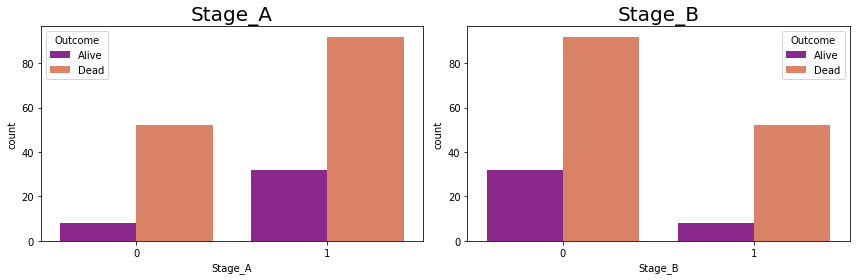

In [376]:
cancer_grade_new_feats = data_complete.columns[79:82]
fig, axs = plt.subplots(1,2,figsize=(12,4))
ax = axs.ravel()
i = 0
for feature in cancer_grade_new_feats:
    sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
    ax[i].set_title(feature, fontsize=20)
    i+=1
fig.tight_layout() 
plt.show()

Hmmmm, Stage A has a higher death rate than Stage B. That's good to know.

Now I'll partition the Age, Survival.Months, and Tumor.Size features. Once this is done, I can start to train and assess the performance of my models.

In [377]:
#Partition Age 50-65 years old and a group of 65+ years old
data_complete['Age_Below65'] = data_complete['Age'].apply(lambda x: 1 if x < 65 else 0)
data_complete['Age_Over65']  = data_complete['Age'].apply(lambda x: 1 if x >= 65 else 0)

#Partition survival months 0-40 months, 40-50 months, and 50+ months
data_complete['Survive_0_40_Months'] = data_complete['Survival.Months'].apply(lambda x: 1 if x <= 40 else 0)
data_complete['Survive_40_50_Months'] = data_complete['Survival.Months'].apply(lambda x: 1 if (x > 40) & (x < 50)  else 0)
data_complete['Survive_Over50_Months'] = data_complete['Survival.Months'].apply(lambda x: 1 if x >= 50 else 0)

#0-6 length units [cm?] and a group of 6+ length units?
data_complete['TumorSize_Under6'] = data_complete['Tumor.Size'].apply(lambda x: 1 if x < 6 else 0)
data_complete['TumorSize_Over6']  = data_complete['Tumor.Size'].apply(lambda x: 1 if x >= 6  else 0)

data_complete

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,CTNNB1,DNMT3A,EGFR,ERBB3,ERBB4,ESR1,FBXW7,FGFR1,FGFR3,FLT4,FOXL2,GNAS,HNF1A,KRAS_Col1,KRAS_Col2,MAP2K2,MET,MLH_Col2,MSH2,MSH6,NF_Col1,NF_Col2,NF_Col3,NF_Col5,NOTCH1,NTRK1,PDGFRB,PIK3CA,PIK3CB,POLD_Col2,PTCH1,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS,Stage_A,Stage_B,Age_Below65,Age_Over65,Survive_0_40_Months,Survive_40_50_Months,Survive_Over50_Months,TumorSize_Under6,TumorSize_Over6
0,1,Alive,9,67,4,0,UNK,2,0,0,IVA,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0
1,2,Dead,19,73,2,0,UNK,2,0,5,IVA,Right Upper Lobe,Adenocarcinoma,3.6,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0
2,3,Dead,13,72,3,0,2,2,0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0
3,4,Dead,15,69,9,1,1a,0,1,0,IA,Right Upper Lobe,Adenocarcinoma,3.6,4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0
4,5,Dead,10,76,9,0,UNK,2,0,0,IIIA,Left Hilar,Large-cell carcinoma,3.6,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,186,Dead,32,82,9,0,4,0,1,0,IIIB,Right Upper Lobe,Squamous cell carcinoma,9.0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1
180,187,Dead,10,62,4,0,3,2,0,0,IVB,Left Hilar,Large-cell carcinoma,3.6,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,1,1,0,1,0,0,1,0
181,188,Dead,23,72,3,0,3,2,0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0
182,189,Dead,32,67,4,1,1a,2,0,0,IVA,Right Upper Lobe,Adenocarcinoma,10.0,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1


And now for a final visualization

In [378]:
data_complete.columns[81:89]

Index(['Age_Below65', 'Age_Over65', 'Survive_0_40_Months',
       'Survive_40_50_Months', 'Survive_Over50_Months', 'TumorSize_Under6',
       'TumorSize_Over6'],
      dtype='object')

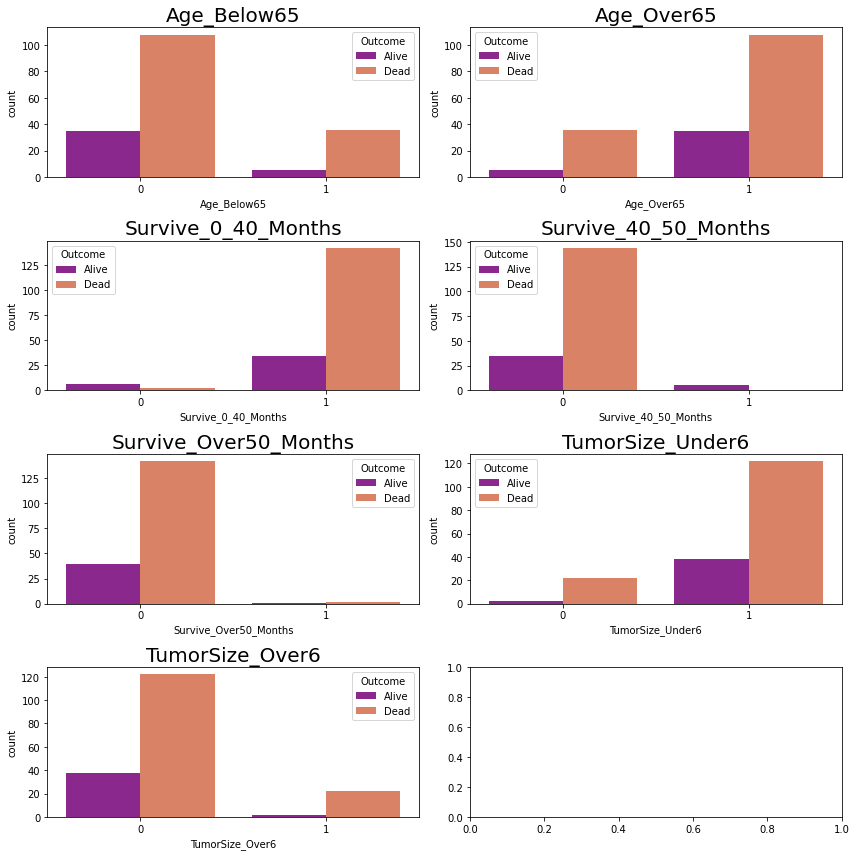

In [379]:
cancer_grade_new_feats = data_complete.columns[81:89]
fig, axs = plt.subplots(4,2,figsize=(12,12))
ax = axs.ravel()
i = 0
for feature in cancer_grade_new_feats:
    sns.countplot(data=data_complete, x=feature, hue='Outcome', palette='plasma',ax= ax[i])
    ax[i].set_title(feature, fontsize=20)
    i+=1
fig.tight_layout() 
plt.show()

Observations:
* Being over 65 years old increases death rate
* Having a tumor under 6 cm increases death rate.

Ok, that's enough feature engineering for now. I'll now start determining what features to look into and then start testing and building models.

## Part 8: One-Hot Encoding, Dimensionality Reduction and Feature Selection
Okay, the data is now cleaned, explored, and I've engineered some new features that may enhance the predictive power of the model. 

Now, I will one hot encode my categorical variables. 

Then, I'll determine which features I can discard from my dataset based on their predictive power. 

I'll use an ANOVA test since I have mixture of numerical and categorical variables present in my dataset.

Before that though, I'll rearrange the order of my columns so that the 'Outcome' column is at the end since this simplifes some subsequent preparations. 

I'll also drop the columns that I won't be needing for my model like Patient ID.

In [380]:
data_complete.nunique()

ID                       184
Outcome                    2
Survival.Months           27
Age                       20
Grade                      4
                        ... 
Survive_0_40_Months        2
Survive_40_50_Months       2
Survive_Over50_Months      2
TumorSize_Under6           2
TumorSize_Over6            2
Length: 88, dtype: int64

In [381]:
#Drop the ID column
data_complete = data_complete.drop(['ID'],axis=1,errors='ignore')

#Convert Outcome column to 0 or 1 (1 = Survive, 0 = Dead)
data_complete['Outcome']  = data_complete['Outcome'].apply(lambda x: 1 if x == 'Alive'  else 0)

#Do one hot encoding
data_complete_ohe = pd.get_dummies(data_complete)
data_complete_ohe

,Outcome,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS,Stage_A,Stage_B,Age_Below65,Age_Over65,Survive_0_40_Months,Survive_40_50_Months,Survive_Over50_Months,TumorSize_Under6,TumorSize_Over6,T_1,T_1a,T_1b,T_2,T_2a,T_2b,T_3,T_4,T_UNK,Stage_1B,Stage_IA,Stage_IIA,Stage_IIB,Stage_IIIA,Stage_IIIB,Stage_IVA,Stage_IVB,Primary.Site_Both Lung,Primary.Site_Left Hilar,Primary.Site_Left Lower Lobe,Primary.Site_Left Upper Lobe,Primary.Site_Right Hilar,Primary.Site_Right Lower Lobe,Primary.Site_Right Middle Lobe,Primary.Site_Right Upper Lobe,Histology_Adenocarcinoma,Histology_Large-cell carcinoma,Histology_Squamous cell carcinoma,AKT1_0,AKT1_1,ALK_Col1_0,ALK_Col1_1,ALK_Col2_0,ALK_Col2_1,APC_0,APC_1,ATM_Col1_0,ATM_Col1_1,ATM_Col2_0,ATM_Col2_1,BRAF_0,BRAF_1,CCND2_0,CCND2_1,CDKN2A_0,CDKN2A_1,CTNNB1_0,CTNNB1_1,DNMT3A_0,DNMT3A_1,EGFR_0,EGFR_1,ERBB3_0,ERBB3_1,ERBB4_0,ERBB4_1,ESR1_0,ESR1_1,FBXW7_0,FBXW7_1,FGFR1_0,FGFR1_1,FGFR3_0,FGFR3_1,FLT4_0,FLT4_1,FOXL2_0,FOXL2_1,GNAS_0,GNAS_1,HNF1A_0,HNF1A_1,KRAS_Col1_0,KRAS_Col1_1,KRAS_Col2_0,KRAS_Col2_1,MAP2K2_0,MAP2K2_1,MET_0,MET_1,MLH_Col2_0,MLH_Col2_1,MSH2_0,MSH2_1,MSH6_0,MSH6_1,NF_Col1_0,NF_Col1_1,NF_Col2_0,NF_Col2_1,NF_Col3_0,NF_Col3_1,NF_Col5_0,NF_Col5_1,NOTCH1_0,NOTCH1_1,NTRK1_0,NTRK1_1,PDGFRB_0,PDGFRB_1,PIK3CA_0,PIK3CA_1,PIK3CB_0,PIK3CB_1,POLD_Col2_0,POLD_Col2_1,PTCH1_0,PTCH1_1,PTEN_0,PTEN_1,RB1_0,RB1_1,SMARCA4_0,SMARCA4_1,SMARCB1_0,SMARCB1_1,SMO_0,SMO_1,STK11_0,STK11_1,TERT_0,TERT_1,TP53_Col1_0,TP53_Col1_1,TP53_Col2_0,TP53_Col2_1,TSC2_0,TSC2_1
0,1,9,67,4,0,2,0,0,1.4,8,8,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1
1,0,19,73,2,0,2,0,5,3.6,2,2,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0
2,0,13,72,3,0,2,0,0,1.5,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0
3,0,15,69,9,1,0,1,0,3.6,4,4,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0
4,0,10,76,9,0,2,0,0,3.6,3,3,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [382]:
#Place Outcome column at the end of the dataframe. Simplifies breaking data into dependent/independent variables later.
new_cols = [col for col in data_complete_ohe.columns if col != 'Outcome'] + ['Outcome']
data_complete_ohe = data_complete_ohe[new_cols]
data_complete_ohe.head()

,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Slow_Growth,Medium_Growth,Fast_Growth,LessLikely_Spread,Likely_Spread,HighlyLikely_Spread,Normal_Cells,Abnormal_Cells,Most_Abnormal_Cells,Spread_To_Lymph_Nodes,Hilar,Right_PS,Left_PS,Stage_A,Stage_B,Age_Below65,Age_Over65,Survive_0_40_Months,Survive_40_50_Months,Survive_Over50_Months,TumorSize_Under6,TumorSize_Over6,T_1,T_1a,T_1b,T_2,T_2a,T_2b,T_3,T_4,T_UNK,Stage_1B,Stage_IA,Stage_IIA,Stage_IIB,Stage_IIIA,Stage_IIIB,Stage_IVA,Stage_IVB,Primary.Site_Both Lung,Primary.Site_Left Hilar,Primary.Site_Left Lower Lobe,Primary.Site_Left Upper Lobe,Primary.Site_Right Hilar,Primary.Site_Right Lower Lobe,Primary.Site_Right Middle Lobe,Primary.Site_Right Upper Lobe,Histology_Adenocarcinoma,Histology_Large-cell carcinoma,Histology_Squamous cell carcinoma,AKT1_0,AKT1_1,ALK_Col1_0,ALK_Col1_1,ALK_Col2_0,ALK_Col2_1,APC_0,APC_1,ATM_Col1_0,ATM_Col1_1,ATM_Col2_0,ATM_Col2_1,BRAF_0,BRAF_1,CCND2_0,CCND2_1,CDKN2A_0,CDKN2A_1,CTNNB1_0,CTNNB1_1,DNMT3A_0,DNMT3A_1,EGFR_0,EGFR_1,ERBB3_0,ERBB3_1,ERBB4_0,ERBB4_1,ESR1_0,ESR1_1,FBXW7_0,FBXW7_1,FGFR1_0,FGFR1_1,FGFR3_0,FGFR3_1,FLT4_0,FLT4_1,FOXL2_0,FOXL2_1,GNAS_0,GNAS_1,HNF1A_0,HNF1A_1,KRAS_Col1_0,KRAS_Col1_1,KRAS_Col2_0,KRAS_Col2_1,MAP2K2_0,MAP2K2_1,MET_0,MET_1,MLH_Col2_0,MLH_Col2_1,MSH2_0,MSH2_1,MSH6_0,MSH6_1,NF_Col1_0,NF_Col1_1,NF_Col2_0,NF_Col2_1,NF_Col3_0,NF_Col3_1,NF_Col5_0,NF_Col5_1,NOTCH1_0,NOTCH1_1,NTRK1_0,NTRK1_1,PDGFRB_0,PDGFRB_1,PIK3CA_0,PIK3CA_1,PIK3CB_0,PIK3CB_1,POLD_Col2_0,POLD_Col2_1,PTCH1_0,PTCH1_1,PTEN_0,PTEN_1,RB1_0,RB1_1,SMARCA4_0,SMARCA4_1,SMARCB1_0,SMARCB1_1,SMO_0,SMO_1,STK11_0,STK11_1,TERT_0,TERT_1,TP53_Col1_0,TP53_Col1_1,TP53_Col2_0,TP53_Col2_1,TSC2_0,TSC2_1,Outcome
0,9,67,4,0,2,0,0,1.4,8,8,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1
1,19,73,2,0,2,0,5,3.6,2,2,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0
2,13,72,3,0,2,0,0,1.5,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0
3,15,69,9,1,0,1,0,3.6,4,4,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0
4,10,76,9,0,2,0,0,3.6,3,3,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0


Great! 

Now for the ANOVA test

In [384]:
#Carry out ANOVA for F-Score
data = data_complete_ohe.copy()
X = data.iloc[:,0:160]  #independent variable columns
y = data.iloc[:,-1]    #dependent variable column 

#Apply SelectKBest to extract best features
bestfeatures = SelectKBest(score_func = f_classif, k = 160)
fit = bestfeatures.fit(X,y)
dfscores  = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#Concatenate two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Attributes','F-Score']  #naming the resulting dataframe columns
anova_df = pd.DataFrame(featureScores.nlargest(160,'F-Score')).reset_index()
anova_df

,index,Attributes,F-Score
0,51,Primary.Site_Left Lower Lobe,39.743994
1,20,Hilar,31.652174
2,59,Histology_Squamous cell carcinoma,27.162342
3,82,EGFR_0,25.135550
4,83,EGFR_1,25.135550
...,...,...,...
155,93,FGFR1_1,0.025281
156,119,NF_Col1_1,0.009038
157,118,NF_Col1_0,0.009038
158,19,Spread_To_Lymph_Nodes,0.004387


I did the ANOVA test on all the features and had it return all the features because I want to see the distribution so that I can assess the F-Score cutoff myself.

From the ANOVA test I can see that the 3 most important features to Outcome are:
Primary.Site_Left Lower Lobe,Hilar, and Histology_Squamous cell carcinoma.

Let me see the distribution of scores.

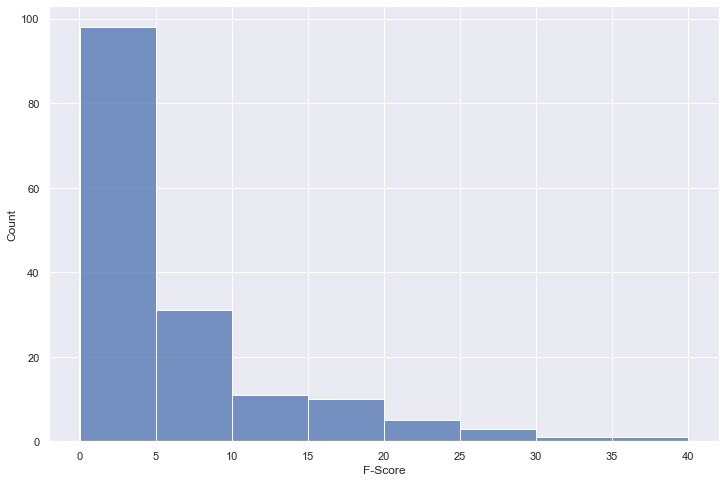

In [390]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data = anova_df , x='F-Score',binwidth=5)
plt.show()

Okay, nearly 100 of the features have an F-score that's between 0-5. Having more features in the model can make the model more accurate but it can also lead to overfitting. 

For this reason, I'll build my model with the features that have F-scores above 5. If more features are needed I can always add them later. 

In [391]:
#Select features with F-Scores above 5
anova_df_FG5 = anova_df.loc[anova_df['F-Score'] >= 5]
anova_df_FG5

,index,Attributes,F-Score
0,51,Primary.Site_Left Lower Lobe,39.743994
1,20,Hilar,31.652174
2,59,Histology_Squamous cell carcinoma,27.162342
3,82,EGFR_0,25.135550
4,83,EGFR_1,25.135550
...,...,...,...
57,4,N,6.303701
58,58,Histology_Large-cell carcinoma,6.187584
59,7,Tumor.Size,6.130046
60,66,APC_0,6.013913


Nice! Now I have 62 features that should have high predictive power for the patient outcome. Let me build my dataframe using these features. 

In [392]:
ini_features_list = anova_df_FG5['Attributes'].tolist()
model_df = data_complete_ohe[data_complete_ohe.columns.intersection(ini_features_list)]
model_df['Outcome'] = data_complete_ohe['Outcome']
model_df

C:\Users\vmurc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Survival.Months,Age,Grade,Num.Primaries,N,Tumor.Size,Slow_Growth,LessLikely_Spread,Normal_Cells,Hilar,Survive_0_40_Months,Survive_40_50_Months,T_1b,T_2a,T_3,Stage_1B,Stage_IA,Stage_IVB,Primary.Site_Left Hilar,Primary.Site_Left Lower Lobe,Primary.Site_Right Hilar,Histology_Adenocarcinoma,Histology_Large-cell carcinoma,Histology_Squamous cell carcinoma,AKT1_0,AKT1_1,ALK_Col1_0,ALK_Col1_1,ALK_Col2_0,ALK_Col2_1,APC_0,APC_1,ATM_Col1_0,ATM_Col1_1,CCND2_0,CCND2_1,CDKN2A_0,CDKN2A_1,CTNNB1_0,CTNNB1_1,DNMT3A_0,DNMT3A_1,EGFR_0,EGFR_1,ERBB4_0,ERBB4_1,FGFR3_0,FGFR3_1,FLT4_0,FLT4_1,FOXL2_0,FOXL2_1,MSH2_0,MSH2_1,NOTCH1_0,NOTCH1_1,PDGFRB_0,PDGFRB_1,POLD_Col2_0,POLD_Col2_1,PTCH1_0,PTCH1_1,Outcome
0,9,67,4,0,2,1.4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1
1,19,73,2,0,2,3.6,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
2,13,72,3,0,2,1.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
3,15,69,9,1,0,3.6,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
4,10,76,9,0,2,3.6,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,32,82,9,0,0,9.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
180,10,62,4,0,2,3.6,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0
181,23,72,3,0,2,2.0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0
182,32,67,4,1,2,10.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0


Beautiful! Now I'm ready to start building and testing models.

## Preparing and Testing Classifier Models

Now that I have my data nice and prepared and have a pretty good understanding of what is going on, I'm finally ready to start testing some classifer models.

Now I'll setup a wrapper function that will allow me to easily train and compare multiple classifiers. It will do this while doing gridsearch and cross validation on the models so the results that I get will be fairly reliable. The results of this function will allow me to determine which models are performing the best which I can then optimize further.

For this project, I'll use cross-validation with k=10 to try to ameliorate the effect of class inbalance. This performs a stratified K-Fold which is better suited to handle inbalanced data. I'll also use class weights whereever possible.

This wrapper function will take the model dataframe, a model definition list, and the dependent variable as inputs. The model definition list is composed of:

    The model initializer,
    The model name
    A dictionary containing the values to use for the grid search

The output of this function will be dataframes containing the results of the models that I trained.

The results will contain the model:

    Accuracy (int)
    Specificity (int)
    Sensitivity (int)
    Training Time (int)
    Best parameters from Grid Search (dict)

In [434]:
def model_assess(X_train, X_test, y_train, y_test, model, grid, title = "Default"):#, class_weights=None):
    """
    Args:
    X_train  : (array) X data for training set
    X_test   : (array) X data for test set
    y_train  : (array) Y data for training set
    y_test   : (array) Y data for test set
    model    : sklearn classifier initialization instance
    grid     : (dict) parameter and parameter values for gridsearch
    title    : (str) Name of classifier
    Returns
    preds_train : (array) predictions using X_train based on best parameters of trained model
    preds_test  : (array) predictions using X_test based on best parameters of trained model
    rf_results  : (dataframe) results of training. Contains accuracy specificity, sensitivity, training time, and best parameters
    """
    start = time.time()
    #Do the parameter grid search
    clf = GridSearchCV(model, param_grid = grid, n_jobs = -1, cv = 10)
    clf.fit(X_train, y_train)#, sample_weight = class_weights)
    
    #Get best parameters for model
    clf_best_params = clf.best_params_
    #Make predictions using best parameters from grid search
    preds_test  = clf.predict(X_test)
    preds_train = clf.predict(X_train) 
    
    #Calculate accuracy metrics
    cm = confusion_matrix(y_test, preds_test)
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    score = round(accuracy_score(y_test, preds_test), 5);
    
    #Get training time for model
    stop = time.time()
    train_time = np.round((stop - start)/60, 2)
    
    #Make dataframe containing model training time
    rf_results = pd.DataFrame([title,score,sensitivity,specificity,train_time,clf_best_params]).transpose()
    rf_results.columns = ['Method','Accuracy Score', 'Sensitivity', 'Specificity','Training Time','Best Parameters']
    
    return preds_train, preds_test, rf_results

def multi_model_assess(df, models, y_predict):
    """
    Args:
    df         : (dataframe) Dataframe containing model features and target variable
    models     : (array) list containing the classifier initiator, the classifier name, and the classifier grid search parameters
    y_predict  : (array) array containing the depedent variable(s) to look into
    Returns
    all_model_results : (array) list containing training results for each model
    all_X_test        : (array) list containing all X_test used 
    all_X_train       : (array) list containing all X_train used
    all_y_test_p      : (array) list containing all predictions using X_test
    all_y_train_p     : (array) list containing all predictions using X_train
    all_y_train       : (array) list containing all X_tests used
    """
    all_model_results = [] #This will contain all model results for each dependent variable 
    all_X_test  = []
    all_X_train = []
    all_y_test_p  = []
    all_y_train_p = []
    all_y_train = []
    all_confusion_mats = []
    #First loop will define dependent/independent variables and split data into test/training sets
    n_vars = len(y_predict)
    
    for dependent in y_predict:
        model_results = [] #Array with dataframes for a given dependent variable
        #Designate independent and dependent variables
        x  = df.drop([dependent], axis = 1)
        y  = df[dependent].astype('int')
        #Split data into test and training sets
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=42)
        
        #Add class weights to account for inbalanced classes
        #class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y_train),y = y_train)
        
        #Populate the array of observed values for the dependent variable
        all_y_train.append(y_train)
        #Add progress bar
        pbar = tqdm(range(len(models)), desc="Variable Processed", position = 0, leave = True) 
        #Process each of the desired models
        for model, model_name,model_grid in models:
            #print(model_name)
            #if (model_name == 'K Neighbors') | (model_name == 'MLP'):
            #   class_weights = None
                
            if model_name == 'XGBoost':
                le = preprocessing.LabelEncoder()
                le.fit(y_train)
                y_train = le.transform(y_train)
                le.fit(y_test)
                y_test = le.transform(y_test)
                
            y_train_pred,y_test_pred, results = model_assess(X_train, 
                                                             X_test, 
                                                             y_train, 
                                                             y_test, 
                                                             model, 
                                                             model_grid, 
                                                             title = model_name)#,
                                                             #class_weights=class_weights)
            
            model_results.append(results)
            all_X_test.append(X_test)
            all_X_train.append(X_train)
            all_y_test_p.append(y_test_pred)
            all_y_train_p.append(y_train_pred)
            pbar.update(1)       
        all_model_results.append(model_results)
        #pbar.update(1)
        pbar.refresh()
        
    pbar.close()   
    return all_model_results, all_X_test, all_X_train, all_y_test_p, all_y_train_p, all_y_train

And now I'll the function and see how the models perform!

In [435]:
#Initialize classifiers
lp = Perceptron(class_weight='balanced')
nb = GaussianNB()
rf = RandomForestClassifier(random_state=0,class_weight='balanced')
bg = BaggingClassifier()
xg = XGBClassifier()
kn = KNeighborsClassifier(weights='distance')
dt = DecisionTreeClassifier(class_weight='balanced')
gb = GradientBoostingClassifier(learning_rate = 0.1,min_weight_fraction_leaf = 0.3)
#gp = GaussianProcessClassifier(random_state=0, n_jobs=-1,max_iter_predict=500)
sv = SVC(class_weight='balanced')
nn = MLPClassifier(max_iter=1000) #Increasing max iteration since the default 200 didn't converge
#cb = CatBoostClassifier(random_state=0, verbose=False)
#lg = LGBMClassifier(random_state=0)

#Define grid search dictionaries for each classifier
lp_grid = {'penalty': ['l2', 'l1'],
           'alpha': [0.00001,0.0001, 0.001]}
nb_grid = {'var_smoothing': [1e-12,1e-11,1e-10, 1e-9]}
rf_grid = {'n_estimators': [200, 250, 300, 400],
           'max_depth': [7, 8, 9, 10, 11]}
bg_grid = {'n_estimators': [300, 400,500]}
xg_grid = {'learning_rate': [0.01, 0.1, 1],
          'max_depth':[1,2,3,4, 5, 6, 7]}
kn_grid = {'n_neighbors': [6, 7, 8, 9,10,11,12,13],
            'p': [1, 2]}
dt_grid = {'max_depth': [6, 7, 8, 9]}
gb_grid = {'n_estimators':[100, 200, 300, 400],
                'max_depth': [1,2,3,4, 5, 6, 7, 8, 9, 10, 11]}
gp_grid ={'kernel':[1*RBF(), 1*DotProduct()]}
sv_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}
nn_grid = {'learning_rate_init':[0.001,0.01,0.1],
          'hidden_layer_sizes':[10,100,200,300]}
cb_grid = {'n_estimators': [100, 150, 200,300],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11]}
lg_grid = {'n_estimators': [100, 150, 200,300],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11]}
#Models is defined by: 
#The model initializer, 
#The model name
#dictionary containing the values to use for the grid search
models =  [(lp,'Perceptron',lp_grid), 
           (nb,'GaussianNB',nb_grid), 
           (rf,'Random Forest',rf_grid), 
           (bg,'Bagging',bg_grid),
           (xg,'XGBoost',xg_grid),
           (kn,'K Neighbors',kn_grid), 
           (dt,'DecisionTree',dt_grid), 
           (gb,'Gradient Boosting',gb_grid), 
           #(gp,'GaussianProcess',gp_grid), Gaussian process takes FOREVER
           (sv,'SVC',sv_grid), 
           (nn,'MLP',nn_grid)]#,
           #(cb,'Cat Boost',cb_grid),
           #(lg,'LGBM',lg_grid)]

#Define column containing the dependent/target variable
y_predict  = ['Outcome']

#Run the multi-model training function
all_model_results, _, _, all_y_test_p, all_y_train_p, all_y_train = multi_model_assess(model_df, models, y_predict)

Variable Processed: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


Great! Let's see the results!

In [436]:
score_df_results = pd.concat(all_model_results[0],
                             ignore_index=True).sort_values('Accuracy Score',axis = 0, ascending = False)
score_df_results

,Method,Accuracy Score,Sensitivity,Specificity,Training Time,Best Parameters
1,GaussianNB,0.97297,0.96875,1.0,0.0,{'var_smoothing': 1e-12}
0,Perceptron,0.91892,0.911765,1.0,0.0,"{'alpha': 0.001, 'penalty': 'l1'}"
2,Random Forest,0.91892,1.0,0.666667,0.1,"{'max_depth': 7, 'n_estimators': 250}"
4,XGBoost,0.91892,0.966667,0.714286,0.02,"{'learning_rate': 1, 'max_depth': 4}"
5,K Neighbors,0.91892,0.911765,1.0,0.0,"{'n_neighbors': 6, 'p': 1}"
8,SVC,0.91892,1.0,0.666667,0.0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
9,MLP,0.91892,0.966667,0.714286,0.05,"{'hidden_layer_sizes': 10, 'learning_rate_init..."
7,Gradient Boosting,0.89189,0.909091,0.75,0.05,"{'max_depth': 2, 'n_estimators': 400}"
3,Bagging,0.86486,0.933333,0.571429,0.04,{'n_estimators': 400}
6,DecisionTree,0.75676,1.0,0.4,0.0,{'max_depth': 6}


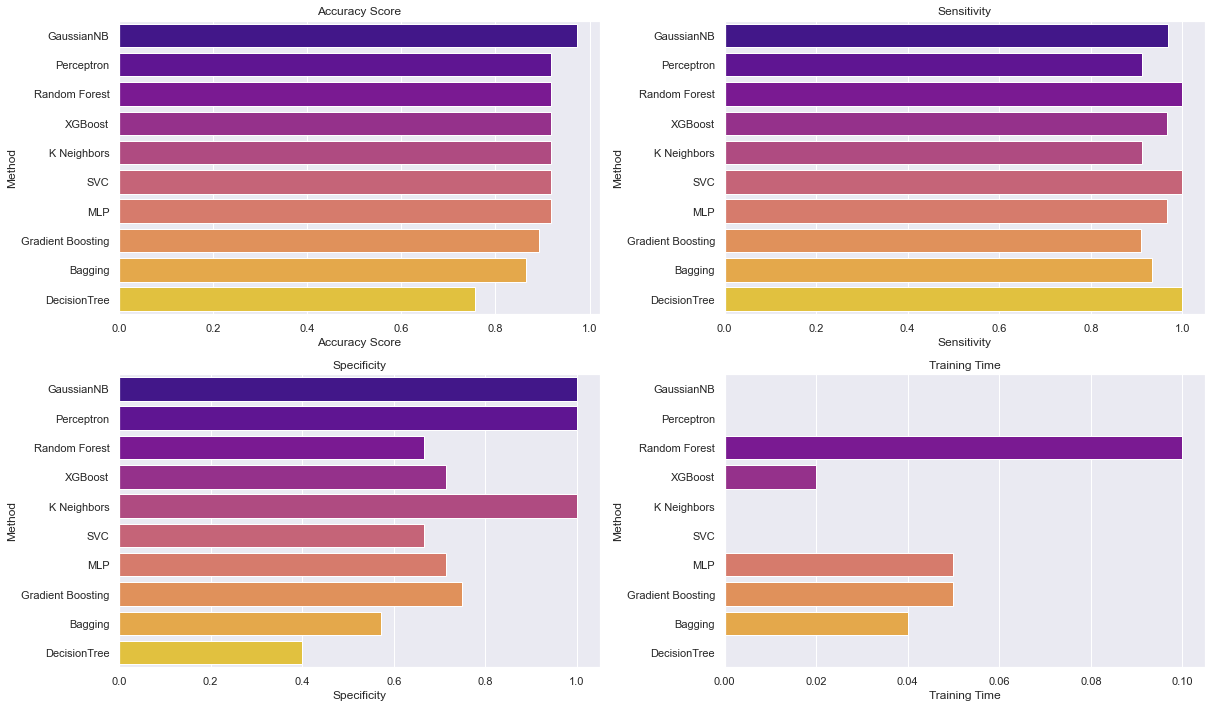

In [437]:
fig, axs = plt.subplots(2,2,figsize=(17,10))
ax = axs.ravel()
features = ['Accuracy Score', 'Sensitivity', 'Specificity', 'Training Time']
i = 0
for feature in features:
    sns.barplot(data=score_df_results, x=feature, y='Method', palette='plasma',ax= ax[i], color = 'm').set_title(feature)
    i+=1
fig.tight_layout() 
plt.show()

The table and the plots above summarize the results of the 10 explored models. 

The GaussianNB, Perceptron, and Random Forest had the highest accuracy, sensitivity, and specificity scores. The GaussianNB didn't give me the option to do class weights so I don't particularly trust the results due to the inbalance. So I'll use SVC classifier since it's the next highest performer that used class weights. Hence, I'll use them for subsequent optimization.

In [460]:
from sklearn.calibration import CalibratedClassifierCV
# Classifiers
best_classifiers = {
    "PER" : Perceptron(**score_df_results['Best Parameters'][0],class_weight='balanced'),
    "SVC" : SVC(**score_df_results['Best Parameters'][8],class_weight='balanced',probability=True),
    "RFC" : RandomForestClassifier(**score_df_results['Best Parameters'][2],class_weight='balanced'),
#    "RFC" : RandomForestClassifier(**score_df_results['Best Parameters'][2]),
#    "XGC" : XGBClassifier(**score_df_results['Best Parameters'][4],verbosity=0),
#    "CBC" : CatBoostClassifier(**score_df_results['Best Parameters'][10],verbose=False),
#    "MLP" : MLPClassifier(**score_df_results['Best Parameters'][9],max_iter=1000),
}

#Split data
y = model_df["Outcome"].astype('int').values
X = model_df.drop(['Outcome'], axis = 1).values
X_test = model_df.drop(['Outcome'], axis = 1).values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1.0, random_state = 42)
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(model_df.shape[0])

for key, classifier in best_classifiers.items():
    start = time.time()
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    score=0
    for train_idx, val_idx in cv.split(X,y):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        if key == 'PER':
            clf_isotonic = CalibratedClassifierCV(clf, cv=10, method='isotonic')
            clf_isotonic.fit(X_train, y_train)
            preds += clf_isotonic.predict_proba(X_test)[:,1]
            score += clf_isotonic.score(X_valid, y_valid)
        else:
            clf.fit(X_train, y_train)
            preds += clf.predict_proba(X_test)[:,1]
            score += clf.score(X_valid, y_valid)
        # Make predictions and measure accuracy
        #preds += clf.predict_proba(X_test)[:,1]
        #score += clf.score(X_valid, y_valid)
    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')

Model: PER
Average validation accuracy: 80.41
Training time (mins): 0.0

Model: SVC
Average validation accuracy: 90.2
Training time (mins): 0.0

Model: RFC
Average validation accuracy: 89.09
Training time (mins): 0.04



<Figure size 864x576 with 0 Axes>

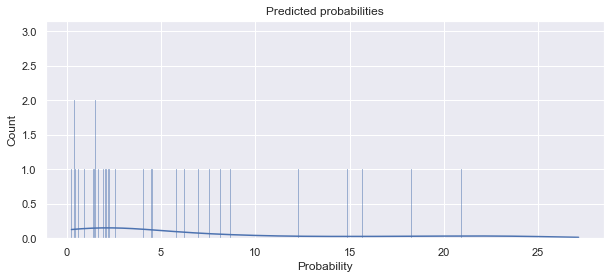

In [461]:
plt.clf()
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')
plt.show()

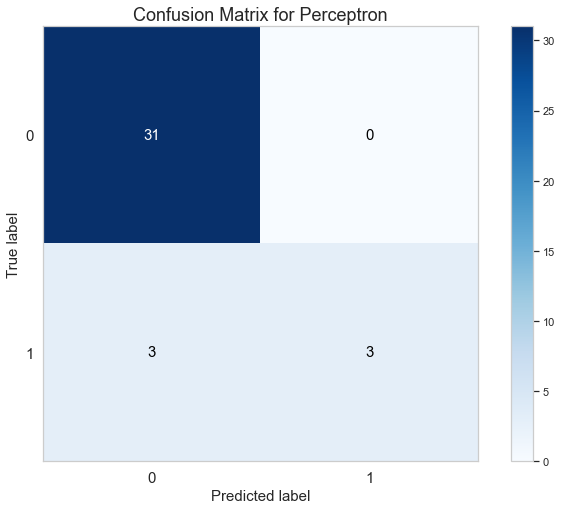

In [476]:
y = model_df['Outcome']
x = model_df.drop(['Outcome'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

per = Perceptron(**score_df_results['Best Parameters'][0],class_weight='balanced')
per.fit(X_train, y_train)

y_per_train_pred = per.predict(X_train) #Predicted y values using training set
y_per_test_pred  = per.predict(X_test) #Predicted y values using test set

plt.rcParams.update({'font.size': 15})
skplt.metrics.plot_confusion_matrix(y_test, y_per_test_pred,
                                    normalize=False, title = 'Confusion Matrix for Perceptron')
plt.show()

The confusion matrix above shows that the model classified 31 entries as True Positives and 3 entries as True Negatives. There were also no False Positives and there were 3 False Negatives. Not bad. 
## ROC-AUC Curves of Model
Let's now look at the Receiver operating characteristic curve (ROC curve) and the area under the curve (AUC) for this model. ROC is a probability curve and AUC represents the degree or measure of separability. The Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability. 

This model has an AUC of 0.75 which is not that great and means more tuning could be done to enhance the class separability. 

The AUC is  0.75


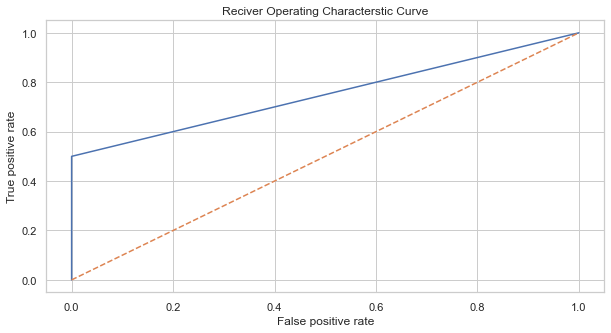

In [474]:
fpr, tpr, thresholds  = roc_curve(y_test,y_per_test_pred)
print("The AUC is ",auc(fpr, tpr))
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.plot(fpr,tpr,label='Gradient Boosting Classifier')
plt.plot([0,1],ls='--')
plt.show()

## What do we make of this?

Let's use the eli5 package to help us make better sense of our model... At least I intended to... It's bugging out at the moment.

In [484]:
#import eli5 --> It's currently not working for me... 
#perm = PermutationImportance(per, random_state=1).fit(X_test, y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

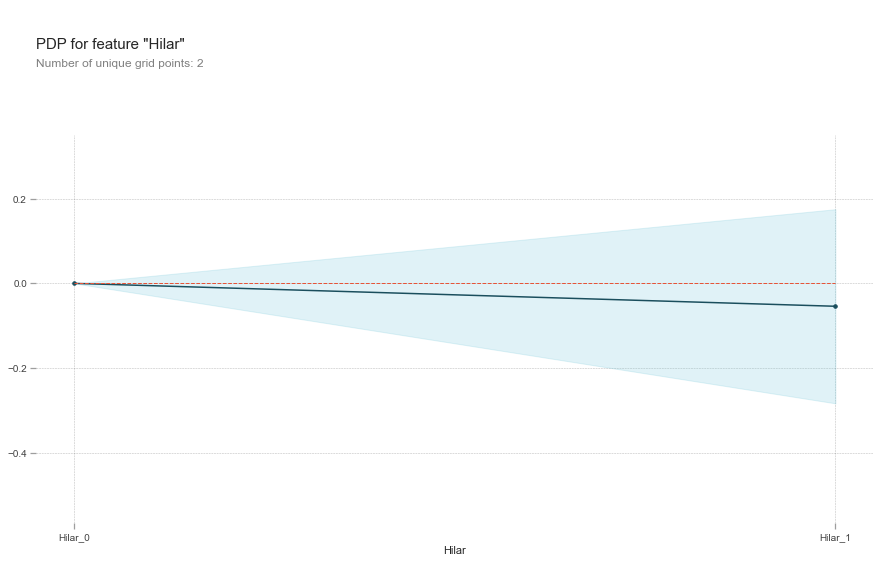

In [488]:
#For generating partial dependence plots
from pdpbox import pdp, info_plots

base_features = model_df.columns.values.tolist()
base_features.remove('Outcome')

feat_name = 'Hilar'
pdp_dist = pdp.pdp_isolate(model=per, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [486]:
#For calculation of shap values to further assess contributions of model features 
import shap